### 1) Initial Imports and loading the utils function. The dataset is used is <a href='https://www.kaggle.com/adityajn105/flickr8k'>Flickr 8k</a> from kaggle.<br>Custom dataset and dataloader is implemented in <a href="https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k">this</a> notebook.

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download adityajn105/flickr8k

! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#imports
data_location =  "/content/Images/"
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import os
from collections import Counter
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split
from torchvision import transforms
import numpy as np
from PIL import Image
# from torch.utils.data import DataLoader,Dataset
# import torchvision.transforms as T

from PIL import Image
from tqdm.auto import tqdm
from torchvision import transforms
#custom imports 
# from data_loader import FlickrDataset,get_data_loader

In [ ]:
spacy_eng = spacy.load("en")

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]  

In [ ]:
import pandas as pd
caption_file = '/content/captions.txt'
df = pd.read_csv(caption_file)

In [ ]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
        
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")
        
        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [ ]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

### 2) **<b>Implementing the Helper function to plot the Tensor image**

In [ ]:
BATCH_SIZE = 8
# BATCH_SIZE = 6
NUM_WORKER = 4

In [ ]:
transforms = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [ ]:
# #show the tensor image
# import matplotlib.pyplot as plt
# def show_image(img, title=None):
#     """Imshow for Tensor."""
    
#     #unnormalize 
#     img[0] = img[0] * 0.229
#     img[1] = img[1] * 0.224 
#     img[2] = img[2] * 0.225 
#     img[0] += 0.485 
#     img[1] += 0.456 
#     img[2] += 0.406
    
#     img = img.numpy().transpose((1, 2, 0))
    
    
#     plt.imshow(img)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
dataset =  FlickrDataset(
    root_dir = '/content/Images/',
    captions_file = '/content/captions.txt',
    transform=transforms
)

pad_idx = dataset.vocab.stoi["<PAD>"]

In [ ]:
len(dataset)

40455

In [ ]:
valid_size = 0.2
n_val = int(np.floor(valid_size * len(dataset)))
n_train = len(dataset) - n_val


train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_dl = DataLoader(dataset=train_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))
valid_dl = DataLoader(dataset=val_ds,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

sample = list(range(2))

sample_train_dl = DataLoader(dataset=torch.utils.data.Subset(train_ds, sample),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))
sample_valid_dl = DataLoader(dataset=torch.utils.data.Subset(val_ds, sample),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#vocab_size
vocab_size = len(dataset.vocab)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 3) Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.efficientnet_b6(pretrained=True)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

In [ ]:
#Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights
        

In [ ]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c


In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


### 4) Setting Hypperparameter and Init the model

In [ ]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2304
decoder_dim=512
learning_rate = 3e-4


In [ ]:
#init model
model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2304,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'/content/outputs/attention_model_state.pth')

## 5) Training Job from above configs

In [ ]:
print_every = 50

In [ ]:

def Accuracy(outputs, targets, k):
    
    batch_size = targets.size(0)
    _, ind = outputs.topk(k,1, True, True)
    print(targets.shape)
    print(targets.reshape(-1, 1).shape)
    correct = ind.eq(targets.reshape(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()
    return correct_total.item()*(100.0/batch_size)

In [ ]:
def train(data_loader, model, criterion, optimizer, epoch):
    
    model.train() 
    for idx, (image, captions) in tqdm(enumerate(data_loader)):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # acc5 = Accuracy(outputs, targets, 5)
        # acc1 = Accuracy(outputs, targets, 1)
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.3f}".format(epoch,loss.item()))#, acc5.item(), acc1.item()))

In [ ]:
def validate(val_dataloader, model,criterion, epoch):
    
    model.eval()
    
    with torch.no_grad():
        for idx, (img, captions) in tqdm(enumerate(val_dataloader)):
            img,captions = img.to(device),captions.to(device)
            
            output, attention = model(img, captions)
            
            targets = captions[:,1:]
            loss = criterion(output.view(-1, vocab_size), targets.reshape(-1))
        
            # acc5 = Accuracy(output, targets, 5)
            # acc1 = Accuracy(output, targets, 1)
            
            print("Validation loss: {:.3f}".format(loss.item()))#, acc5.item(), acc1.item()))

In [ ]:
# num_epochs = 10

# for epoch in tqdm(range(1,num_epochs+1)):
    
#     train(train_dl, model, criterion, optimizer, epoch)
#     validate(valid_dl, model,criterion, epoch)

    
#     # with torch.no_grad():
#     #     dataiter = iter(sample_valid_dl)
#     #     img,_ = next(dataiter)
#     #     features = model.encoder(img[0:1].to(device))
#     #     caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
#     #     caption = ' '.join(caps)
#     #     show_image(img[0],title=caption)
        
#     #save the latest model
# save_model(model,epoch)

In [ ]:
# model = EncoderDecoder(
#     embed_size=300,
#     vocab_size = len(dataset.vocab),
#     attention_dim=256,
#     encoder_dim=2304,
#     decoder_dim=512
# ).to(device)

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/T2I2T/attention_model_state.pth",map_location=torch.device('cpu'))['state_dict'])
# model.eval()

<All keys matched successfully>

In [ ]:
model.eval()

EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): ConvNormActivation(
                (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
                (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
             

## 6 Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [ ]:
#show the tensor image
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [ ]:
#show any 1
# dataiter = iter(valid_dl)
# images,_ = next(dataiter)

# img = images[0].detach().clone()
# img1 = images[0].detach().clone()
# caps,alphas = get_caps_from(img.unsqueeze(0))

# plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
# dataiter = iter(valid_dl)
# images,_ = next(dataiter)

# img = images[0].detach().clone()
# img1 = images[0].detach().clone()
# caps,alphas = get_caps_from(img.unsqueeze(0))

# plot_attention(img1, caps, alphas)

In [ ]:
#show any 1
# dataiter = iter(valid_dl)
# images,_ = next(dataiter)

# img = images[0].detach().clone()
# img1 = images[0].detach().clone()
# caps,alphas = get_caps_from(img.unsqueeze(0))

# plot_attention(img1, caps, alphas)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


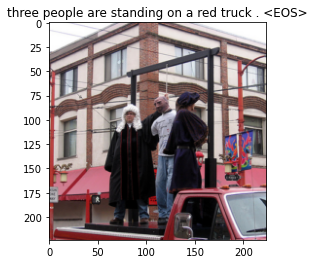

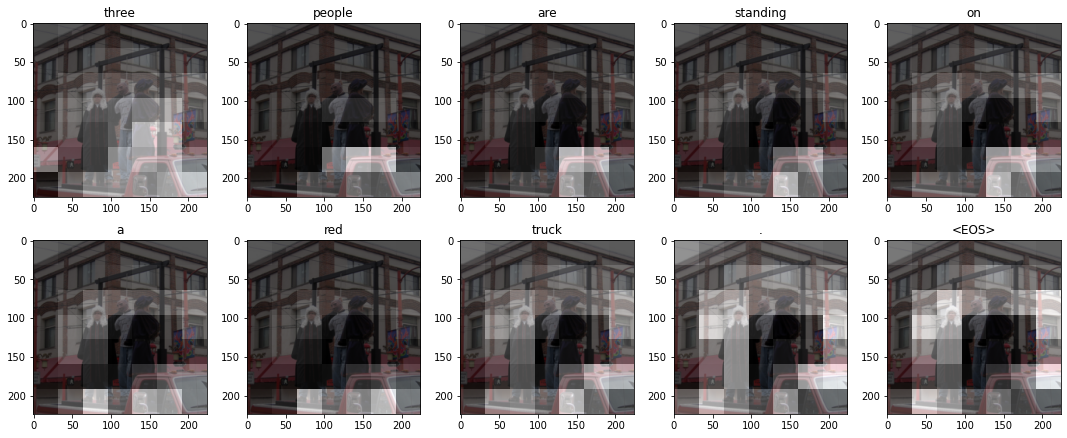

In [ ]:
#show any 1
dataiter = iter(valid_dl)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

In [ ]:
from torchvision import transforms

import numpy as np
from PIL import Image

In [ ]:

transforms_test = T.Compose([
    T.Resize((224, 224)),                                  
    T.ToTensor(),                               
   
])

In [ ]:
# def gradio_pred(img):
#   image = Image.fromarray(img)
#   image = image.convert("RGB")
#   # img = Image.open(img_path)
#   image = transforms_test(image)
#   # plt.imshow(image.permute(1,2,0))
#   # plt.show()
#   image = image[np.newaxis, ...]
#   caps, alphas = get_caps_from(image)
#   return " ".join(caps[:-1])

In [ ]:
!pip install -q gradio

In [ ]:

import gradio

def gradio_pred(img):
  image = Image.fromarray(img)
  image = image.convert("RGB")
  image = transforms_test(image)
  image = image[np.newaxis, ...]
  caps, alphas = get_caps_from(image)
  return " ".join(caps[:-1])

gradio.Interface(gradio_pred, inputs = "image", outputs= "text").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://41797.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7fe844072d50>,
 'http://127.0.0.1:7861/',
 'https://41797.gradio.app')